In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,UpSampling2D,Dropout
from tensorflow.keras.models import Model

In [2]:
mkdir checkpoints

In [3]:
X = np.load("../input/teeth-segmentation-npy-files/X.npy")
Y = np.load("../input/teeth-segmentation-npy-files/Y.npy")
X.shape, Y.shape

((464, 512, 512, 1), (464, 512, 512, 1))

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [5]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((371, 512, 512, 1), (93, 512, 512, 1), (371, 512, 512, 1), (93, 512, 512, 1))

In [6]:
def UNET (input_shape=(512,512,1),last_activation='sigmoid'):
    model = Sequential()

    #Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    #Decoder
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
    
    return model

model = UNET()
model.summary()

2022-09-22 11:52:35.189766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 11:52:35.310237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 11:52:35.311081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 11:52:35.313031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      2

In [7]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 1)

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

In [8]:
import tensorflow as tf
model_ckt = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints/",
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
)
learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                           mode = 'max',
                                                           factor = 0.1, 
                                                           patience = 20, 
                                                           verbose = 1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                 patience = 20, 
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                  verbose=1)

callbacks_list = [learningrate_scheduler, early_stopping, model_ckt]

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', dice_coef, IOU, specificity,
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision')])

history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=8,
          epochs=200,
          verbose=1,
          callbacks = callbacks_list)

2022-09-22 11:52:40.027676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-09-22 11:52:43.062597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 17s 149ms/step - loss: 0.4389 - accuracy: 0.8101 - dice_coef: 0.5487 - IOU: 0.3817 - specificity: 0.8727 - recall: 0.7941 - precision: 0.7019 - val_loss: 0.5247 - val_accuracy: 0.7523 - val_dice_coef: 0.1792 - val_IOU: 0.0984 - val_specificity: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: saving model to ./checkpoints/
Epoch 2/200
47/47 [==============================] - 5s 109ms/step - loss: 0.2907 - accuracy: 0.8658 - dice_coef: 0.6508 - IOU: 0.4828 - specificity: 0.9360 - recall: 0.8219 - precision: 0.8610 - val_loss: 0.6370 - val_accuracy: 0.7523 - val_dice_coef: 0.0996 - val_IOU: 0.0524 - val_specificity: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: saving model to ./checkpoints/
Epoch 3/200
47/47 [==============================] - 5s 109ms/step - loss: 0.2191 - accuracy: 0.8772 - dice_coef: 0.7065 - IOU: 0.5471 - specificity: 0.9476 - recall: 0.8367 - precision: 0.8930 - val_loss: 0

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("model_history.csv")

In [11]:
hist_df

,loss,accuracy,dice_coef,IOU,specificity,recall,precision,val_loss,val_accuracy,val_dice_coef,val_IOU,val_specificity,val_recall,val_precision,lr
0,0.438876,0.810111,0.548676,0.381729,0.872682,0.794078,0.701881,0.524652,0.752267,0.179167,0.098410,1.000000,0.000000,0.000000,0.001000
1,0.290652,0.865768,0.650803,0.482776,0.935965,0.821930,0.860955,0.637029,0.752267,0.099619,0.052421,1.000000,0.000000,0.000000,0.001000
2,0.219091,0.877174,0.706525,0.547066,0.947648,0.836702,0.893041,0.772064,0.752267,0.052847,0.027140,1.000000,0.000000,0.000000,0.001000
3,0.176956,0.884055,0.749826,0.600200,0.957546,0.831646,0.915557,0.804549,0.752267,0.045440,0.023247,1.000000,0.000000,0.000000,0.001000
4,0.149984,0.889144,0.782160,0.642547,0.965281,0.826383,0.931851,0.978401,0.752267,0.020301,0.010254,1.000000,0.000000,0.000000,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.040881,0.914799,0.939068,0.885139,0.993390,0.869268,0.993542,0.066905,0.907871,0.923632,0.858142,0.988378,0.855464,0.983465,0.000001
184,0.040913,0.914798,0.939020,0.885054,0.993432,0.869066,0.993584,0.066902,0.907876,0.923651,0.858174,0.988352,0.855660,0.983426,0.000001
185,0.040912,0.914800,0.939081,0.885163,0.993363,0.869317,0.993545,0.066910,0.907870,0.923627,0.858133,0.988374,0.855517,0.983450,0.000001
186,0.040846,0.914805,0.939148,0.885280,0.993399,0.869458,0.993549,0.066909,0.907867,0.923615,0.858113,0.988362,0.855541,0.983429,0.000001


In [12]:
model.save('unet_four.h5')

In [13]:
pred = model.predict(X_test)

In [14]:
from sklearn.metrics import f1_score
import numpy as np

predict_img1=(pred>0.25)*1
y_test1=(Y_test>0.25)*1
f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9775252803679435

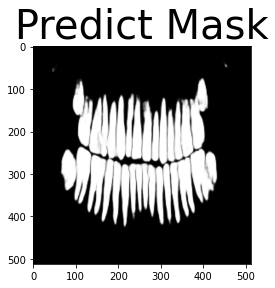

In [15]:
# plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(pred[50,:,:,0], cmap='gray')

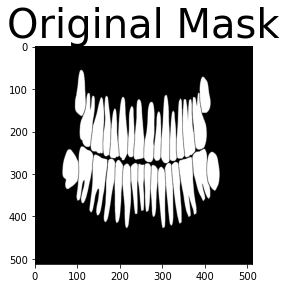

In [16]:
plt.title("Original Mask",fontsize = 40)
plt.imshow(Y_test[50,:,:,0], cmap='gray')